In [1]:
import sys
copypath = ['../models', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python27.zip', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/plat-linux2', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-tk', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-old', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/lib-dynload', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/site-packages', 
            '/home/ec2-user/miniconda2/envs/keras-training/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg']
for p in reversed(copypath):
    sys.path.insert(0, p)
import setGPU

setGPU: Setting GPU to: 0


In [2]:
%matplotlib inline

In [3]:
import h5py
import glob
import numpy as np

In [4]:
#need afs password to read from eos
#import os
#import getpass
#os.system("echo %s| kinit" %getpass.getpass())

## MERGE SOME tt file

In [5]:
#features = np.array([])
#truth = np.array([])
#raw = np.array([])
#first = True
#os.system("rm ../DATA/ttbar_lepFilter_13TeV_JetImage.h5")
#for fileName in glob.glob("/eos/cms/store/cmst3/group/dehep/TOPGEN/Delphes/ttbar_lepFilter_13TeV/ttbar_lepFilter_13TeV_100*jetImage.h5"):
#for fileName in glob.glob("/eos/cms/store/cmst3/group/dehep/TOPGEN/Delphes/ttbar_lepFilter_13TeV/ttbar_lepFilter_13TeV_*jetImage.h5"):
#    myFile = h5py.File(fileName)
#    mytruth = myFile.get('jetMomenta')
#    myraw = myFile.get('rawJetMomenta')
#    myfeatures = myFile.get('jetImages')    
#    truth = np.concatenate((truth,mytruth), axis=0) if truth.size else mytruth
#    raw = np.concatenate((raw,myraw), axis=0) if raw.size else myraw
#    features = np.concatenate((features,myfeatures), axis=0) if features.size else myfeatures
#print(features.shape, truth.shape, raw.shape)
#fileOut = h5py.File("../DATA/ttbar_lepFilter_13TeV_JetImage.h5", "w")
#fileOut.create_dataset('jetMomenta', data=truth,compression='gzip')
#fileOut.create_dataset('rawJetMomenta', data=raw,compression='gzip')
#fileOut.create_dataset('jetImages', data=features,compression='gzip')
#fileOut.close()

In [6]:
# delete datasets
#del truth, raw, features
#del mytruth, myraw, myfeatures

In [4]:
# open the new dataset
fileIn = h5py.File("../DATA/ttbar_lepFilter_13TeV_JetImage.h5")
truth = fileIn.get("jetMomenta")
raw = fileIn.get("rawJetMomenta")
features = fileIn.get("jetImages")

# show average image

In [5]:
sumImage = np.sum(features,axis=0)
print(sumImage.shape)

(20, 20, 2)


In [6]:
caloImage = sumImage[:,:,0]
trkImage = sumImage[:,:,1]

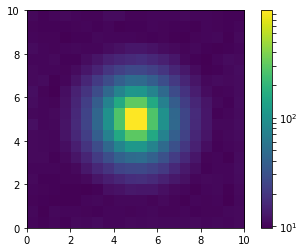

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.imshow(caloImage/caloImage.shape[0], 
               extent=[0, 10, 0, 10], 
               origin='lower', 
               norm=colors.LogNorm())

plt.colorbar()

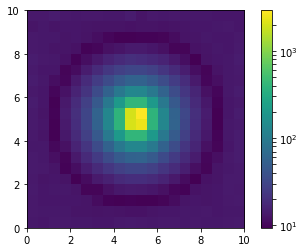

In [8]:
plt.imshow(trkImage/trkImage.shape[0], 
           extent=[0, 10, 0, 10], 
           origin='lower',
           norm=colors.LogNorm())
plt.colorbar()

# Prepare train and test samples



In [9]:
print(raw.shape)

(693052, 4)


In [10]:
from sklearn.preprocessing import MinMaxScaler
# normalize raw inputs and outputs between 0 and 1
scaler = MinMaxScaler()
print(scaler.fit(raw))
maxVal = scaler.data_max_
minVal = scaler.data_min_
raw = (raw-minVal)/(maxVal-minVal)
truth = (truth-minVal)/(maxVal-minVal)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [11]:
# we only care about the jet pT. So we forget about eta and phi
truth = truth[:,0]
truth = np.reshape(truth, (truth.shape[0], 1))
print(truth.shape)

(693052, 1)


In [12]:
iSplit = int(0.7*truth.shape[0])
x_image_train = features[:iSplit, :, :, :]
x_image_test = features[iSplit:, :, :, :]
x_raw_train = raw[:iSplit, :]
x_raw_test = raw[iSplit:, :]
y_train = truth[:iSplit, :]
y_test = truth[iSplit:, :]

In [13]:
x_image_test = np.reshape(x_image_test, (x_image_test.shape[0], x_image_test.shape[1],
                                         x_image_test.shape[2], x_image_test.shape[3], 1))
x_image_train = np.reshape(x_image_train, (x_image_train.shape[0], x_image_train.shape[1],
                                           x_image_train.shape[2], x_image_train.shape[3], 1))

In [14]:
print(x_raw_test.shape, x_raw_train.shape)
print(x_image_test.shape, x_image_train.shape)

((207916, 4), (485136, 4))
((207916, 20, 20, 2, 1), (485136, 20, 20, 2, 1))


# build the model

In [15]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv3D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization, Lambda
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


In [16]:
#batch_size = 128
batch_size = 1024
img_rows, img_cols = 20, 20
nImages = 2

In [88]:
image_shape = (img_rows, img_cols, nImages, 1)
####
# this is the raw pT
InputRaw = Input(shape=(4,))
x2 = BatchNormalization(momentum=0.6)(InputRaw)
# this is the input image
inputImage = Input(shape=(image_shape))
x = BatchNormalization(momentum=0.6)(inputImage)
x = Conv3D(5, kernel_size=(3, 3, 2), data_format="channels_last", strides=(1, 1, 1), 
           activation='relu', kernel_initializer='lecun_uniform', input_shape=image_shape)(x)
x = Dropout(0.1)(x)
#x = MaxPooling3D(pool_size=(2, 2, 1))(x)
# from 3D to 2D
print(x.shape)
x = Reshape((18, 18, 5), input_shape=(18, 18, 1, 5))(x)
x = Conv2D(1, kernel_size=(3, 3), strides=(1, 1), 
           activation='relu', kernel_initializer='lecun_uniform', input_shape=image_shape)(x)
x = Dropout(0.1)(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
dense = Concatenate(axis=1)([x, x2])
dense = Dense(10, activation='relu', kernel_initializer='lecun_uniform')(dense)
dense = Dropout(0.1)(dense)
output = Dense(1, activation='linear', kernel_initializer='lecun_uniform')(dense)
#output = Dense(2, activation='linear', kernel_initializer='ones')(dense)
#output_original = Lambda(lambda y: y[:1], output_shape=(1,))(output)
####
#model = Model(inputs=[InputRaw,inputImage], outputs=[output_original,output])
model = Model(inputs=[InputRaw,inputImage], outputs=output)

(?, 18, 18, 1, 5)


In [18]:
def loss_NLL(y_true, x):
    """
    This loss is the negative log likelyhood for gaussian pdf.
    See e.g. http://bayesiandeeplearning.org/2016/papers/BDL_29.pdf for details
    Generally it might be better to even use Mixture density networks (i.e. more complex pdf than single gauss, see:
    https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf
    """
    x_pred = x[:,:1]
    #x_sig = x[:,1:]
    x_sig = K.clip(K.abs(x[:,1:]),K.epsilon(),None)
    return K.mean(0.5* K.log(K.square(x_sig))  + K.square(x_pred - y_true)/(K.square(x_sig))/2.,    axis=-1)
    #x_pred = x
    #return K.mean(K.square(x_pred - y_true)/2.,    axis=-1)

In [90]:
#model.compile(loss='logcosh', optimizer='rmsprop')
#from keras.optimizers import Nadam
#nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004, clipnorm=1.)

#model.compile(loss=['logcosh',loss_NLL], loss_weights=[1.,0.1], optimizer='adam')

model.compile(loss='logcosh', optimizer='rmsprop')
model.summary()
# plot graph
# plot_model(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 20, 20, 2, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 20, 20, 2, 1) 4           input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 18, 18, 1, 5) 95          batch_normalization_4[0][0]      
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 18, 18, 1, 5) 0           conv3d_2[0][0]                   
__________________________________________________________________________________________________
reshape_2 

In [91]:
# train 
history = model.fit([x_raw_train, x_image_train], y_train, epochs=150, batch_size=batch_size, verbose = 2,
                validation_data=([x_raw_test, x_image_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 485136 samples, validate on 207916 samples
Epoch 1/150
 - 12s - loss: 5.3132e-04 - val_loss: 2.2568e-05
Epoch 2/150
 - 11s - loss: 2.7533e-05 - val_loss: 2.1267e-05
Epoch 3/150
 - 11s - loss: 2.4911e-05 - val_loss: 1.7735e-05
Epoch 4/150
 - 12s - loss: 2.4126e-05 - val_loss: 1.4437e-05

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 5/150
 - 12s - loss: 2.2163e-05 - val_loss: 1.4207e-05
Epoch 6/150
 - 12s - loss: 2.2391e-05 - val_loss: 1.3520e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000475e-05.
Epoch 7/150
 - 11s - loss: 2.1426e-05 - val_loss: 1.4252e-05
Epoch 8/150
 - 12s - loss: 2.1861e-05 - val_loss: 1.4202e-05

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.00000006569e-06.
Epoch 9/150
 - 12s - loss: 2.1948e-05 - val_loss: 1.3941e-05
Epoch 10/150
 - 11s - loss: 2.1454e-05 - val_loss: 1.3698e-05

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.00000011116e-07.
Epoch 11/150
 - 11s - loss: 2.2

# Loss at early stop:
- Adam with mse: 
       Epoch 28/150 / loss: 8.5737e-05 - val_loss: 5.9542e-05
       CNN MEAN: -0.221108 / CNN RMS: 0.689300
       
- Adam with logcosh: 
        Epoch 40/150 / loss: 4.2010e-05 - val_loss: 2.3856e-05
        CNN MEAN: -0.225471 / CNN RMS: 0.590492

- Adadelta with mse: 
        Epoch 24/150 / loss: 9.2832e-05 - val_loss: 6.1209e-05
        CNN MEAN: -0.230359 CNN RMS: 0.685298


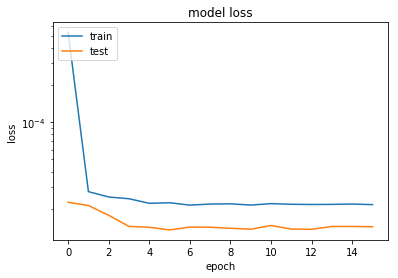

In [92]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#

In [93]:
ptPredict = model.predict([x_raw_test, x_image_test])
#print([p.shape for p in ptPredict])
ptPredict = np.reshape(ptPredict, (ptPredict.shape[0],))

In [94]:
#put pT back in its range
pTraw = minVal[0] + x_raw_test[:,0]*(maxVal[0]-minVal[0])
pTreco = minVal[0] + np.reshape(y_test, (y_test.shape[0],))*(maxVal[0]-minVal[0])
ptPredict = minVal[0] + ptPredict*(maxVal[0]-minVal[0])

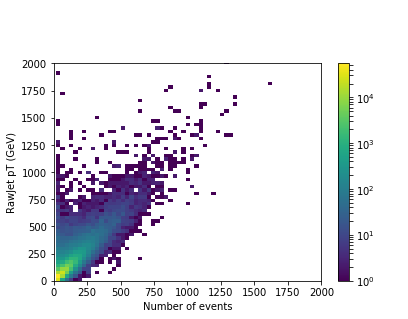

In [95]:
from matplotlib.colors import LogNorm
# pT resolution before regression
plt.hist2d(pTreco, pTraw, bins=80, norm=LogNorm())
plt.xlim((0.,2000.))
plt.ylim((0.,2000.))
plt.ylabel('RawJet pT (GeV)')
plt.xlabel('PFJet pT (GeV)')
plt.xlabel('Number of events')
plt.colorbar()
plt.show()

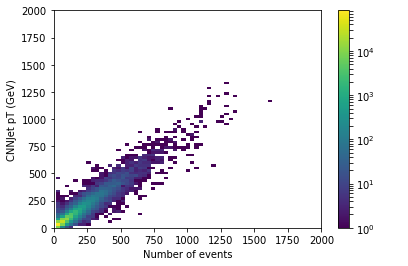

In [96]:
# pT resolution after regression
plt.hist2d(pTreco, ptPredict, bins=80, norm=LogNorm())
plt.xlim((0.,2000.))
plt.ylim((0.,2000.))
plt.ylabel('CNNJet pT (GeV)')
plt.xlabel('PFJet pT (GeV)')
plt.xlabel('Number of events')
plt.colorbar()
plt.show()

In [97]:
print(pTreco.shape, ptPredict.shape)

((207916,), (207916,))


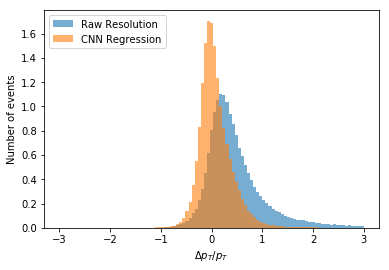

RAW MEAN: 0.596268
RAW RMS: 1.263742
-------------------
CNN MEAN: 0.078278
CNN RMS: 0.367158


In [98]:
#plt.xlim(-7., 3.)
# histtype = 'step'
resRaw = np.nan_to_num((pTraw-pTreco)/pTreco)
resCNN = np.nan_to_num((ptPredict-pTreco)/pTreco)
bins = np.linspace(-3, 3, 100, endpoint=True)
plt.hist(resRaw, bins = bins, normed=1, alpha = 0.6)
plt.hist(resCNN, bins = bins, normed=1, alpha = 0.6)
plt.ylabel('Number of events')
plt.xlabel('$\Delta p_T/p_T$')
plt.legend(['Raw Resolution','CNN Regression', ], loc='upper left')
plt.show()
from scipy.stats import norm
(mu, sigma) = norm.fit((pTraw-pTreco)/pTreco)
print("RAW MEAN: %f" %mu)
print("RAW RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit((ptPredict-pTreco)/pTreco)
print("CNN MEAN: %f" %mu)
print("CNN RMS: %f" %sigma)

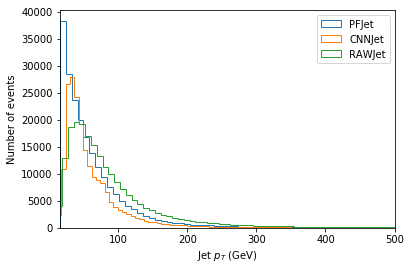

In [100]:
# plot pT spectra
plt.xlim(15., 500.)
countsDEN, binsDEN, barsDEN = plt.hist(pTreco, bins = 300, histtype = 'step')
countsNUM, binsNUM, barsNUM = plt.hist(ptPredict, bins = 300, histtype = 'step')
countsNUMRAW, binsNUMRAW, barsNUMRAW = plt.hist(pTraw, bins = 300, histtype = 'step')
plt.ylabel('Number of events')
plt.xlabel('Jet $p_T$ (GeV)')
plt.legend(['PFJet','CNNJet','RAWJet'], loc='upper right')
plt.show()

In [101]:
bins = np.array(binsNUM)
bins = bins+(bins[1]-bins[0])/2.
bins = bins[:-1]

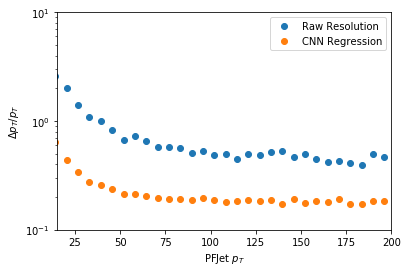

In [102]:
# build the profile plots for resolution vs pT [BY HAND!!!!]
binEdge = np.array(binsNUM)
meanRAW = []
errRAW = []
meanCNN = []
errCNN = []
for i in range(len(binEdge)-1):
    inBin = (pTreco >= binEdge[i]) * (pTreco < binEdge[i+1])
    populationRAW = resRaw[inBin]
    populationCNN = resCNN[inBin]
    #
    (mu, sigma) = norm.fit(populationRAW)
    meanRAW.append(mu)
    errRAW.append(sigma)
    #
    (mu, sigma) = norm.fit(populationCNN)
    meanCNN.append(mu)
    errCNN.append(sigma)
errRAW = np.array(errRAW)
errCNN = np.array(errCNN)
# resolution vs pT
plt.xlim(15., 200.)
# LOG SCALE
plt.yscale('log')
plt.ylim(0.1, 10.)
# LINEAR
#plt.ylim(0., 5.)
# histtype = 'step'
plt.plot(bins, errRAW,"o")
plt.plot(bins, errCNN, "o")
plt.ylabel('$\Delta p_T/p_T$')
plt.xlabel('PFJet $p_T$')
plt.legend(['Raw Resolution','CNN Regression', ], loc='upper right')
plt.show()

106878
106253
106767


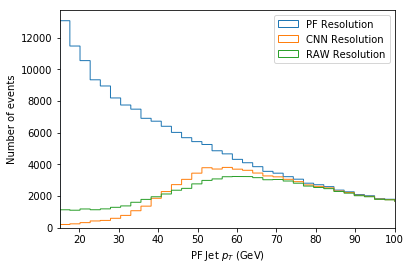

In [159]:
# now build ingredients to the turn-on curves
plt.xlim(15., 100.)
print len(pTreco[pTreco>45.1])
print len(pTreco[ptPredict>45.])
print len(pTreco[pTraw>65.])
countsDEN, binsDEN, barsDEN = plt.hist(pTreco, bins = 1000, histtype = 'step')
countsNUM, binsNUM, barsNUM = plt.hist(pTreco[ptPredict>45.], bins = 1000, histtype = 'step')
countsNUMRAW, binsNUMRAW, barsNUMRAW = plt.hist(pTreco[pTraw>65.], bins = 1000, histtype = 'step')
plt.ylabel('Number of events')
plt.xlabel('PF Jet $p_T$ (GeV)')
plt.legend(['PF Resolution','CNN Resolution','RAW Resolution'], loc='upper right')
plt.show()

In [160]:
bins = np.array(binsNUM)
bins = bins+(bins[1]-bins[0])/2.
bins = bins[:-1]

In [161]:
countsNUM = np.array(countsNUM)
countsDEN = np.array(countsDEN)
countsNUMRAW = np.array(countsNUMRAW)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


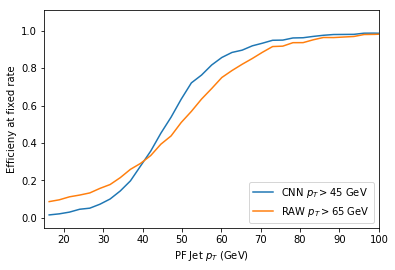

In [163]:
# build efficiencies 
eff_CNN = np.nan_to_num(countsNUM/countsDEN)
#err_CNN = np.nan_to_num(np.sqrt(eff_CNN*(1.-eff_CNN)/countsDEN))
#
eff_RAW = np.nan_to_num(countsNUMRAW/countsDEN)
#err_RAW = np.nan_to_num(np.sqrt(eff_RAW*(1.-eff_RAW)/countsDEN))
#
plt.xlim(15., 100.)
plt.plot(bins, eff_CNN)
plt.plot(bins, eff_RAW)
#
plt.ylabel('Efficieny at fixed rate')
plt.xlabel('PF Jet $p_T$ (GeV)')
plt.legend(['CNN $p_T>45$ GeV','RAW $p_T>65$ GeV'], loc='lower right')
plt.show()

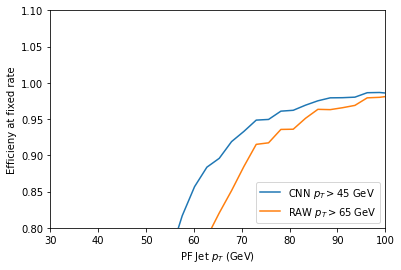

In [165]:
plt.xlim(30., 100.)
plt.ylim(0.8, 1.1)
plt.plot(bins, eff_CNN)
plt.plot(bins, eff_RAW)
#
plt.ylabel('Efficieny at fixed rate')
plt.xlabel('PF Jet $p_T$ (GeV)')
plt.legend(['CNN $p_T>45$ GeV','RAW $p_T>65$ GeV'], loc='lower right')
plt.show()

In [166]:
print(np.sum(ptPredict>40.)/len(pTreco))
print(np.sum(pTraw>40.)/len(pTreco))

0
0


In [ ]:
# to do: compare the result with what one gets from a Delphes reco with the same worsening of the resolution
# - 10% on photons
# - 20% on neutral hadrons
# - 15% on charged particles